In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u, constants as const
import sys
sys.path.append('/home/gusinskaia/screens')
#from screens.fields import dynamic_field, theta_grid
from screens.fields import dynamic_field


In [3]:
import sys
sys.path.insert(1, '/home/gusinskaia/scintools/scintools')
import ththmod as THTH

In [37]:
from glob import glob
import os, math, time
from astropy.time import Time
from astropy.visualization import quantity_support#, time_support
from astropy import constants as const

import astropy
from matplotlib.colors import LogNorm

import matplotlib as mpl
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth
import wsrt_fits as wf

quantity_support()
plt.rcParams['figure.dpi'] = 50

In [5]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
nsdir=trdir+'dss_wsrt_wnoise/'
list_obs=sorted(glob(nsdir+'*wns.npz'))
print (len(list_obs))

214


In [6]:
def plot_hex(mjd,vel, size=40,colorbar=True, vmin=None, vmax=None, cmap='seismic', fclr='w'):
    pb_i =1.6293932
    #pb_o = par_dict['pb_o']
    plt.set_cmap(cmap)
    ax=plt.subplot()
    ax.set_facecolor(fclr)
    im=plt.hexbin(mjd,(mjd/pb_i)%1,vel,size,linewidths=0.1, vmin=vmin, vmax=vmax) 
    plt.ylabel("inner phase")
    plt.xlabel("MJD")
    if colorbar:
        cb = plt.colorbar(im)
        cb.set_label('veff/deff^0.5')
    return
mjd_year = 55197
year_mjd = 2010
def day_to_year(mjd):
    return (mjd-mjd_year)/365.2425+year_mjd

In [8]:
def plot_folded(mjds,pars, pars_err,ylab=r'v$_{eff}$ / d$_{eff}$ $^{0.5}$  (mean)', mjd_ref=None, new_fig=True,
               scatter=False, color='grey', ms=6):
    if new_fig is True:
        plt.figure(figsize=(5,3), dpi=150)
    Pb_d=1.6293932
    if mjd_ref is None:
        mjd_ref=np.amin(mjds)
    phase_folded_unq=np.mod((mjds-mjd_ref),Pb_d)
    plt.errorbar(phase_folded_unq/Pb_d,pars, yerr=np.array(pars_err), color=color, ls='None', marker='o', ms=ms)
    if scatter is True:
        plt.scatter(phase_folded_unq/Pb_d,pars, c=pars, zorder=2)
    plt.ylabel(ylab)
    plt.xlabel('Phase of the inner orbit')

In [7]:
import pickle
list_pickles=sorted(glob('*.pickle'))
len(list_pickles)

264

In [9]:
import pickle
#list_pickles=sorted(glob('long_obs_fit_results/*wnz_nored*.pickle'))
list_pickles=sorted(glob('*nodof*.pickle'))
print (len(list_pickles))

dv_ind_all,dv_ind_all_err, dv_ovl_all,dv_ovl_all_err=[],[],[],[]
dv_ind_sim,dv_ind_sim_err, dv_ovl_sim,dv_ovl_sim_err=[],[],[],[]
mjds_dvs=[]
for i in range(0,len(list_pickles)):
    res_pickle=pickle.load(open(list_pickles[i], 'rb'))
    
    
    
    dv_ind, dv_err_ind, fr_ind=[],[],[]
    dv_ovl, dv_err_ovl,  fr_ovl=[],[],[]
    for i in range(0,len(res_pickle['res_ind'][0])):
        dv_ind.append(res_pickle['res_ind'][0][i]['dveff'].value)
        dv_err_ind.append(res_pickle['res_ind'][0][i]['dveff_err'].value)
        fr_ind.append(res_pickle['res_ind'][0][i]['mean_f'].value)
    for i in range(0,len(res_pickle['res_ovlp_'][0])):   
        dv_ovl.append(res_pickle['res_ovlp_'][0][i]['dveff'].value)
        dv_err_ovl.append(res_pickle['res_ovlp_'][0][i]['dveff_err'].value)
        fr_ovl.append(res_pickle['res_ovlp_'][0][i]['mean_f'].value)
    
    dv_ind_all.append(np.mean(dv_ind))
    dv_ind_all_err.append(np.std(dv_ind))
    dv_ovl_all.append(np.mean(dv_ovl))
    dv_ovl_all_err.append(np.std(dv_ovl))
    dv_ind_sim.append(res_pickle['res_ind_sim'][0].value)
    dv_ind_sim_err.append(res_pickle['res_ind_sim'][1].value)
    dv_ovl_sim.append(res_pickle['res_ovlp_sim'][0].value)
    dv_ovl_sim_err.append(res_pickle['res_ovlp_sim'][1].value)
    mjds_dvs.append(res_pickle['res_ovlp_'][0][0]['mean_t'])

263


In [10]:
dv_ovl_all_all,dv_ovl_all_all_err=dv_ovl_all,dv_ovl_all_err
dv_ovl_sim_all,dv_ovl_sim_all_err=dv_ovl_sim,dv_ovl_sim_err
dv_ind_sim_all,dv_ind_sim_all_err=dv_ind_sim,dv_ind_sim_err
mjds_dvs_all=mjds_dvs

Text(0, 0.5, 'veff/deff^0.5')

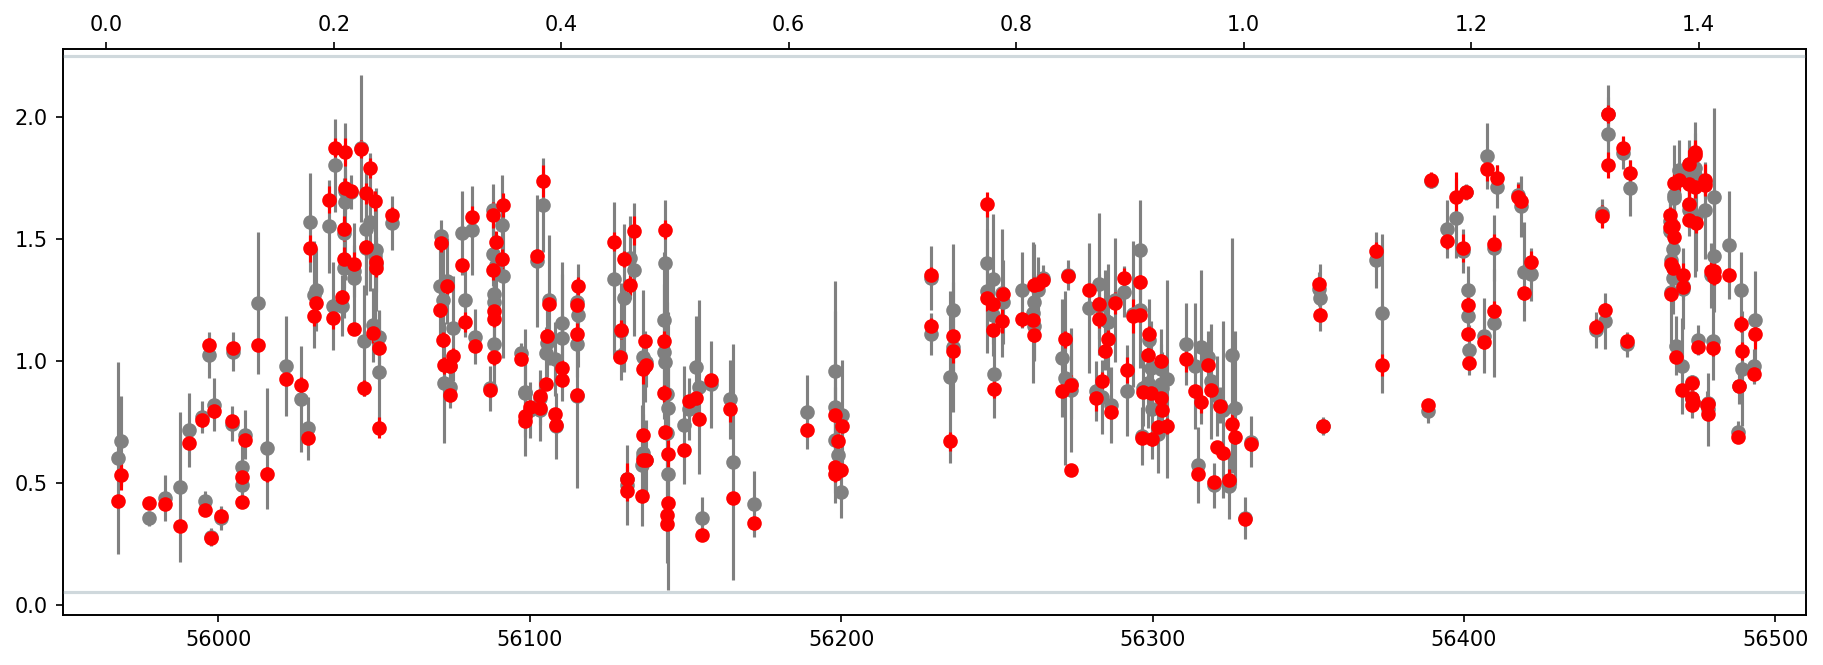

In [11]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none')
plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)

ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
plt.ylabel('veff/deff^0.5')

#ax2.set_xlim(day_to_year(d_n), day_to_year(d_x))

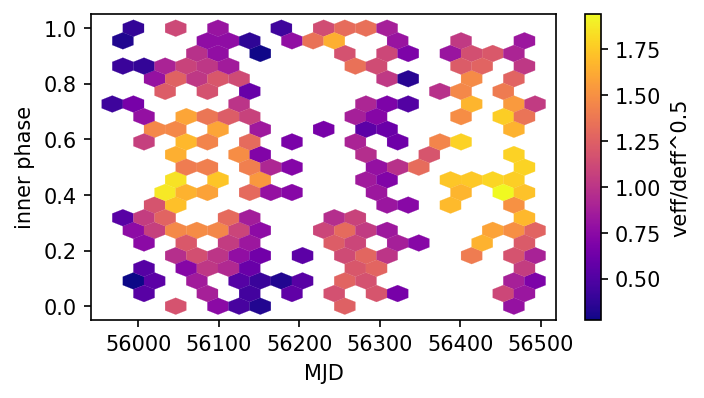

In [12]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_all)-0.18,np.array(dv_ovl_sim_all), size=20,cmap='plasma')
         #fclr=np.array([207, 216, 220])/255.)#, vmin=0.5,vmax=1.5)

In [25]:
from astropy.coordinates import EarthLocation, SkyOffsetFrame, SkyCoord

In [26]:
PB_i=1.6293932*u.day
PB_o=327.25685*u.day
a_i=1.92379*const.c.to('cm/s').value
a_o=117.992*const.c.to('cm/s').value
e_i=6.9e-4
e_o=3.5e-2
omg_i=97.5638*u.deg
omg_o=95.6212*u.deg
i_ang=39.263*u.deg
T_asc0_i=Time(55920.40771662, format='mjd')
T_asc0_o=Time(56233.93512, format='mjd')
dp=1300*u.pc

asini_i=1.2175252*u.s*const.c
asini_o=74.672629*u.s*const.c



orb_par_i={'Pb':PB_i, 'a':a_i, 'e':e_i,'omg':omg_i, 'i':i_ang, 'Tasc0':T_asc0_i}
orb_par_o={'Pb':PB_o, 'a':a_o, 'e':e_o,'omg':omg_o, 'i':i_ang, 'Tasc0':T_asc0_o}

In [33]:
#wsrt_loc=EarthLocation.from_geodetic('6d36m7.19s','52d54m31.79s')
wsrt_loc=EarthLocation('6d36m7.19s','52d54m31.79s')
#wsrt_loc.geodetic

coords = SkyCoord('03 37 43.82589 +17 15 14.8280', unit=(u.hourangle, u.deg))

psr = SkyCoord(ra=coords.ra, dec=coords.dec,
               pm_ra_cosdec=5.90*u.mas/u.yr, pm_dec=-4.02*u.mas/u.yr,
               distance=1300*u.pc)

psr_frame = SkyOffsetFrame(origin=psr)

hh=psr.pm_ra_cosdec.to('mas/yr')
hh

<Quantity 5.9 mas / yr>

In [28]:
def orb_mean_vel(asini, pb):
    k=2.*math.pi*asini/pb
    return k

def phase_orbit(t,T0,pb):
    th_p = ((t - T0) / pb).to('') * u.cycle
    return th_p
  
def earth_vel(t, psr_frame, tel_loc):
    pos = tel_loc.get_gcrs(t).transform_to(psr_frame).cartesian
    vel = pos.differentials['s']
    return vel.d_xyz.to(u.km / u.s)

def mu_to_vel(mu,distance):
    mu=mu.to('mas/yr').value
    d=distance.to(u.pc).value
    vel=(mu*4.74*d*1e-3)*u.km/u.s
    return vel
    

In [29]:
# ╭∩╮

In [151]:
s=0.6
ds=(1-s)*dp
D_eff=dp*ds/(dp-ds)

Omg_s=105*u.deg

Omg_p=(44-14)*u.deg# from Voisin et al. 2020
dOmg_p=Omg_s-Omg_p

bsp =   (np.cos(dOmg_p) * D_eff**0.5) / (dp * np.sin(i_ang))
bcp = - (np.sin(dOmg_p) * D_eff**0.5) / (dp * np.tan(i_ang))

bse = np.sin(Omg_s) / (D_eff**0.5)
bce = np.cos(Omg_s) / (D_eff**0.5)

v_pm_ra  = mu_to_vel(psr.pm_ra_cosdec, D_eff)
v_pm_dec = mu_to_vel(psr.pm_dec, D_eff)

V_ism=-10*u.km/u.s

dveff_c = (V_ism/s - (v_pm_ra*np.cos(Omg_s) + v_pm_dec*np.sin(Omg_s)))/D_eff**0.5

In [152]:
t=Time(np.array(mjds_dvs_all), format='mjd')

#t=np.arange(mjds_dvs_all[0],mjds_dvs_all[-1], 0.25)
#t=Time(t, format='mjd')


Kp_i=orb_mean_vel(asini_i, PB_i)
Kp_o=orb_mean_vel(asini_o, PB_o)

ph_i=phase_orbit(t, T_asc0_i, PB_i)
ph_o=phase_orbit(t, T_asc0_o, PB_o)

Ve=earth_vel(t, psr_frame, wsrt_loc)
Ve_ra=Ve[1]
Ve_dec=Ve[2]


dveff_model = (bsp * (Kp_i * np.sin(ph_i) + Kp_o * np.sin(ph_o))
             + bcp * (Kp_i * np.cos(ph_i) + Kp_o * np.cos(ph_o))
             - Ve_ra * bse - Ve_dec * bce + dveff_c)
               

Text(0, 0.5, 'veff/deff^0.5')

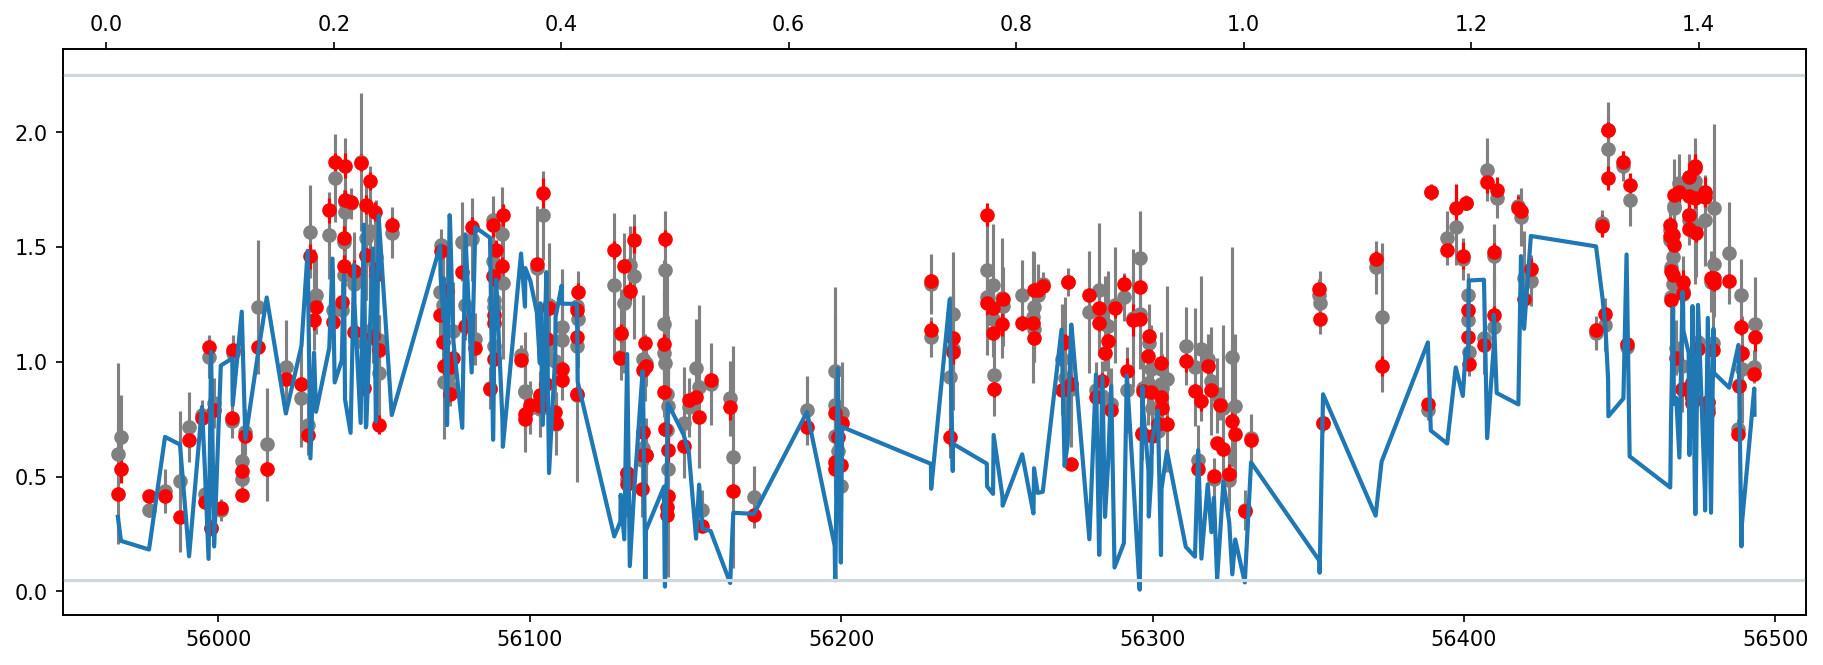

In [155]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none')
plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)

ax1.plot(t.mjd, np.abs(dveff_model.to(u.km/u.s/u.pc**0.5).value), lw=2, zorder=3)
ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
plt.ylabel('veff/deff^0.5')


Text(0, 0.5, 'veff/deff^0.5')

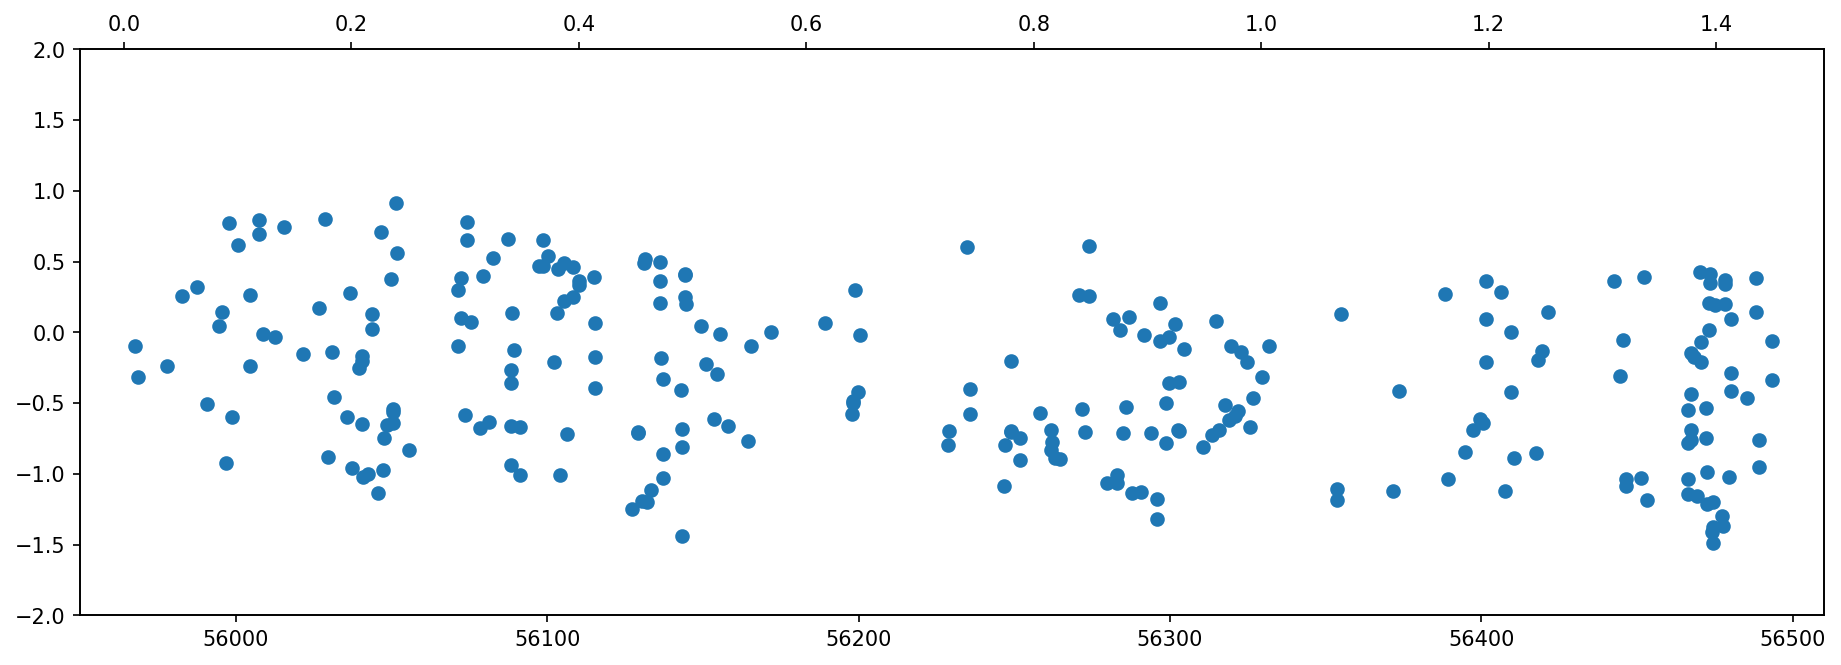

In [154]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
residuals=np.abs(dveff_model.to(u.km/u.s/u.pc**0.5).value)-np.array(dv_ovl_sim_all)
ax1.plot(t.mjd,residuals, zorder=3, ls='none', marker='o')
ax1.set_xlim(55950,56510)
ax1.set_ylim(-2,2)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
plt.ylabel('veff/deff^0.5')